# ROB 498: Robot Learning for Planning and Control
# Final Project: GPs for Bayesian Optimization

## Colab Setup

### Setup Code 

In [1]:
%load_ext autoreload
%autoreload 2

The below cell will check you have the required files in your directory. The file `mppi.py` will be released on 02/19/2023, so you should expect to see 'Required file `mppi.py` not found!' before then. This is because there may still be students working on Homework 2 until then. This file is not needed until Section 4 of the homework. 

In [3]:
import os
import sys

files = os.listdir()
expected_files = [ 'ROB498_hw3.ipynb', 'learning_state_dynamics.py', 'panda_pushing_env.py', 'visualizers.py',  'mppi.py', 'validation_data.npy']

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')

All required files are found :)


In [4]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm
from learning_state_dynamics import collect_data_random
from learning_state_dynamics import process_data_single_step, SingleStepDynamicsDataset

pybullet build time: May 20 2022 19:44:17


## Assignment Introduction

Due 3/8 at 11:59pm

**Rules**:

1. All homework must be done individually, but you are encouraged to post questions on Piazza

2. No late homework will be accepted (unless you use your late-day tokens)

3. Submit your code on [autograder.io](http://autograder.io/)

4. Remember that copying-and-pasting code from other sources is not allowed

5. The use of additional package imports beyound the packages we provide is not allowed. The autograder will not grade your code if you use additional packages.

**Instructions**
- Each problem will give you a file with some template code, and you need to fill in the
rest.
- We use the autograder, so if you’re ever wondering “will I get full points for
this?” just upload your code in the autograder to check. There is no limit to how
many times you can upload to autograder.
- The autograder may test your problem with multiple different inputs to make sure it is correct.
- The autograder will only show you if you got it right/wrong, so if you don’t get full points, try to test with some other inputs.

# Planar Pushing Learning (100 points)
For this assignment we will train a robot to push an object to a goal pose.
To this end, you will have to collect dynamics data, process the data, train a model of the dynamics, and use it for planning a sequence of pushes to reach the target location.



## Simulation Environment Introduction

For our planar pushing setup, we will use PyBullet to simulate a panda robot that pushes a block on top of a table.
The pushing block is visualized in white. In green, we visualize the goal pose of the block.



In [5]:
from panda_pushing_env import PandaPushingEnv
from visualizers import GIFVisualizer, NotebookVisualizer

Run the following code block to visualize the robot pushing the block.

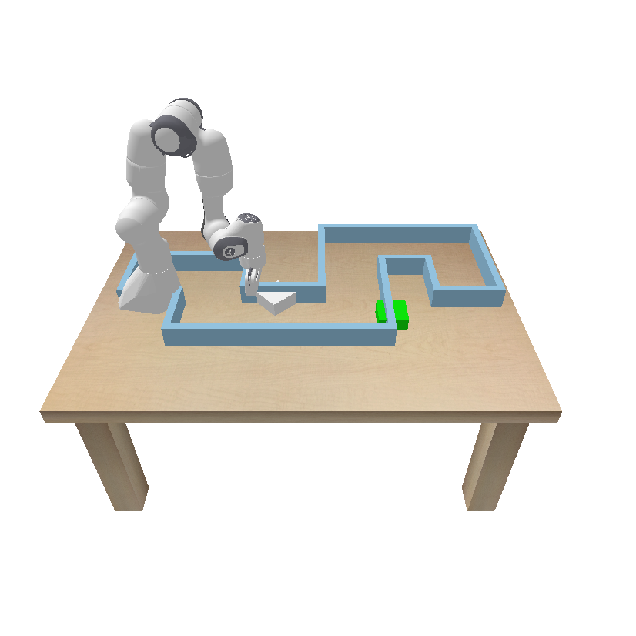

argv[0]=--opengl2
argv[0]=--opengl2


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=True,  camera_heigh=800, camera_width=800)
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  include_obstacle=True, camera_heigh=800, camera_width=800, render_every_n_steps=5)

env.reset()

# Perform a sequence of 3 random actions:
for i in tqdm(range(3)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        break

plt.close(fig)

For speeding up the visualization, we will only visualize the pushing part of the robot motion. However, be aware of the full robot motion.

There is another option for visualization, which is to create a `.gif` file. The following cell shows an example of this. Note that here we set the rendering mode to just render the push motion for efficiency.

In [ ]:
# Create the GIF visualizer
visualizer = GIFVisualizer()

# Initialize the simulation environment. This will only render push motions, omitting the robot reseting motions.
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False, camera_heigh=500, camera_width=500, render_every_n_steps=5)
env.reset()

# Perform a sequence of 3 random actions:
for i in tqdm(range(10)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        break

# Create and visualize the gif file.
Image(filename=visualizer.get_gif())



Rendering is useful for visualizing the implementation's performance and debugging. However, it consumes resources and takes time to produce. The following cell will perform 100 pushes without rendering. Compare the time with the previous rendering approaches. This should be an order of magnitude faster.

In [ ]:
# Simulate pushing without rendering - this should take about 30s.
visualizer = None # No redering

env = PandaPushingEnv(visualizer=visualizer)
env.reset()

pbar =  tqdm(range(100)) # We will perform 100 pushes.

for i in pbar:
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        env.reset()


### State Space and Action Space

For the planar pushing task, we have the following action and state spaces:

The image below illustrates the state space, which is the block planar location on top of the table. 
$$
\mathbf x = \begin{bmatrix} x & y & \theta\end{bmatrix}^\top\in \text{SE}(2)
$$
Note that the state contains only position elements, and not velocity terms. This is because we assume that the pushing task is *quasi-static*. This means that the pushing actions are slow enough that the velocity and inertia of the block are negligible. In other words, if the robot stops pushing, the block also stops.


![State Space](https://drive.google.com/uc?export=view&id=1iuHwUC_IVsrBbgbyiR8qXDV4OBmgKObU)

Note that the robot is centered at the origin. 


The following image show the robot action space. 

![Action Space](https://drive.google.com/uc?export=view&id=1sFyNOAj-RmNbwk_Ww8VxmmkCaW4LpVZj)

Each action $\mathbf u = \begin{bmatrix} p & \phi & \ell\end{bmatrix}^\top\in \mathbb R^3$ is composed by:
* $p \in [-1,1]$: pushing location along the lower block edge.
* $\phi \in [-\frac{\pi}{2},\frac{\pi}{2}]$ pushing angle.
* $\ell\in [0,1]$ pushing length as a fraction of the maximum pushing length. The maximum pushing length is is 0.1 m



### Gym Environments

Our planar pushing task has been wrapped into a `gym` environment. You can find more information about the gym environments [here](https://gymnasium.farama.org/api/env/).

As a gym enviroment, our pushing enviroment has the following useful methods:

* `step`: Given an action vector, it performs the action in the simulator and returns 
    1. `state`: The resulting state, i.e. $s_{t+1}$
    2. `reward`: Not used here (useful for Reinforcement Learning tasks).
    3. `done`: Boolean. In our case the simulation is done (`done=True`) if the robot has reached the goal location or if the block has left the bounds of the workspace.
    4. `info`: Dictionary containing additional data. Not used here.
Example:
```python
state, reward, done, info = env.step(action_i)
```
* `reset`: Resets the simulation to the initial state. It returns the inital state after reset.
Example:
```python
    state = env.reset()
```

Moreover, our pushing environment has the following attributes:
* `env.action_space`: Represents the action space, following the described parametrization above.
* `env.observation_space`: Represents the state space (block pose in $SE(2)$)
These are `gym.spaces` and therefore you can sample them using `.sample()`.
Example:
```python
action_i = env.action_space.sample()
```
This produces actions uniformly sampled from the action space.

You can find more info about gym spaces [here](https://gymnasium.farama.org/api/spaces/).



## 1 - Collect Data  (15 points)

Given the environment, the first step is to collect data. The collected data will then be used to train a model of the pushing dynamics.

**TODO:**

* Implement `collect_data_random` in `learning_state_dynamics.py` which collects data trajectories. The actions should be uniformly random sampled within the action space limits.


**OBSERVATION**: Data collection may take some time. Please be patient and do not close the session while you are collecting data or the data collection process may be interrupted. Once the data is collected it will be saved, so if you restart the kernel you will not need to recollect the data.


**GRADING**: For grading you will also have to submit the saved collected data file `collected_data.npy`. We will check that the collected data is in the required format. However, we will NOT check the quality of the data. Note that for training a good model, data quality is key. Your collected data should be diverse to train an effective model of pushing dynamics.


In [ ]:
# Collect data (it may take some time)
from learning_state_dynamics import collect_data_random
# Data collection parameters
N = 100 # Number of trajectories
T = 10 # Trajectory length

# Initialize the environment and collect data
env = PandaPushingEnv()
env.reset()
collected_data = collect_data_random(env, num_trajectories=N, trajectory_length=T)


# Verify the number of data collected:
print(f'We have collected {len(collected_data)} trajectories')
print('A data sample contains: ')
for k, v in collected_data[0].items():
    assert(type(v) == np.ndarray)
    assert(v.dtype == np.float32)
    print(f'\t {k}: numpy array of shape {v.shape}')

# Save the collected data into a file
np.save(os.path.join(GOOGLE_DRIVE_PATH, 'collected_data.npy'), collected_data)


In [ ]:
# Load the collected data: 
collected_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'collected_data.npy'), allow_pickle=True)

## 2 - Data Processing (20 points)
Next, given the collected data you will have to process it so we can use it for training the model.


### 2.1 - Single Step Data (10 points)

Here we will process the data in a single-step format. 


**TODO:**

* Implement `process_data_single_step` in `learning_state_dyanmics.py` to pack the collected data into a Dataset and returns a DataLoader for training and for validation.
You should do this via the following steps:
 1. Implement `SingleStepDynamicsDataset` which wraps the collected data into a PyTorch Dataset.
    * For this part you only need to implement the `__getitem__` method which returns the data $(\mathbf x_t, \mathbf u_t, \mathbf x_{t+1})$ as a dictionary
    * Your dataset should consist of all $(\mathbf x_t, \mathbf u_t, \mathbf x_{t+1})$ in the collected data
 2. You should instantiate your `SingleStepDynamicsDataset` using the entire dataset, and use `torch.utils.data.random_split` to split the dataset into train and validation sets.  https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split. You should do a 80%-20% split.
 3. You should return a DataLoader for the training and validation set which loads batches of the data of the required `batch_size`.

In [ ]:
# Process the data
from learning_state_dynamics import process_data_single_step, SingleStepDynamicsDataset

batch_size = 500
train_loader, val_loader = process_data_single_step(collected_data, batch_size=batch_size)

# let's check your dataloader

# you should return a dataloader
print('Is the returned train_loader a DataLoader?')
print('Yes' if isinstance(train_loader, torch.utils.data.DataLoader) else 'No')
print('')

# You should have used random split to split your data - 
# this means the validation and training sets are both subsets of an original dataset
print('Was random_split used to split the data?')
print('Yes' if isinstance(train_loader.dataset, torch.utils.data.Subset) else 'No')
print('')

# The original dataset should be of a SingleStepDynamicsDataset
print('Is the dataset a SingleStepDynamicsDataset?')
print('Yes' if isinstance(train_loader.dataset.dataset, SingleStepDynamicsDataset) else 'No')
print('')

# we should see the state, action and next state of shape (batch_size, 3)
for item in train_loader:
    print(f'state is shape {item["state"].shape}')
    print(f'action is shape {item["action"].shape}')
    print(f'next_state is shape {item["next_state"].shape}')
    break


Is the returned train_loader a DataLoader?
Yes

Was random_split used to split the data?
Yes

Is the dataset a SingleStepDynamicsDataset?
Yes

state is shape torch.Size([500, 3])
action is shape torch.Size([500, 3])
next_state is shape torch.Size([500, 3])


### 2.2 - Multi-step Data  (10 points)

Here we will process the data in a multi-step format. 


**TODO:**

* Implement `process_data_multiple_step` in `learning_state_dyanmics.py` to pack the collected data into a Dataset and return a DataLoader for training and for validation.
You should do this via the following steps:
 1. Implement `MultiStepDynamicsDataset` which wraps the collected data into a PyTorch Dataset.
    * For this part you only need to implement the `__getitem__` method which returns $(\mathbf x_t, \mathbf u_t, ..., \mathbf u_{t+k-1}, \mathbf x_{t+1}, ... , \mathbf x_{t+k})$, where $k$ is `num_steps`. We will be using `num_steps=4`. 
    * Your dataset should consist of all subtrajectories of the above form in the dataset. For instance, the trajectory $[(\mathbf x_1,\mathbf  u_1), (\mathbf x_2, \mathbf u_2), (\mathbf x_3, \mathbf u_3), (\mathbf x_4, \mathbf u_4), (\mathbf x_5, \mathbf u_5), (\mathbf x_6, \mathbf u_6), (\mathbf x_7)]$ should result in the following items in the dataset:
        - $(\mathbf x_1, \mathbf u_1, \mathbf u_2, \mathbf u_3, \mathbf u_4, \mathbf x_2, \mathbf x_3, \mathbf x_4, \mathbf x_5)$
        - $(\mathbf x_2, \mathbf u_2, \mathbf u_3, \mathbf u_4, \mathbf u_5, \mathbf x_3, \mathbf x_4, \mathbf x_5, \mathbf x_6)$
        - $(\mathbf x_3, \mathbf u_3, \mathbf u_4, \mathbf u_5, \mathbf u_6, \mathbf x_4, \mathbf x_5, \mathbf x_6, \mathbf x_7)$
 2. You should instantiate your `MultiStepDynamicsDataset` using the entire dataset, and use `torch.utils.data.random_split` to split the dataset into train and validation sets  https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split. You should do a 80%-20% split.
 3. You should return a DataLoader for the training and validation set which loads batched of the data of the required `batch_size`.

In [ ]:
# Process the data
from learning_state_dynamics import process_data_multiple_step, MultiStepDynamicsDataset


train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=500)

# let's check your dataloader

# you should return a dataloader
print('Is the returned train_loader a DataLoader?')
print('Yes' if isinstance(train_loader, torch.utils.data.DataLoader) else 'No')
print('')

# You should have used random split to split your data - 
# this means the validation and training sets are both subsets of an original dataset
print('Was random_split used to split the data?')
print('Yes' if isinstance(train_loader.dataset, torch.utils.data.Subset) else 'No')
print('')

# The original dataset should be of a MultiStepDynamicsDataset
print('Is the dataset a SingleStepDynamicsDataset?')
print('Yes' if isinstance(train_loader.dataset.dataset, MultiStepDynamicsDataset) else 'No')
print('')

# we should see the state is shape (batch_size, 3)
# and action, next_state are shape (batch_size, num_steps, 3)
for item in train_loader:
    print(f'state is shape {item["state"].shape}')
    print(f'action is shape {item["action"].shape}')
    print(f'next_state is shape {item["next_state"].shape}')
    break

Is the returned train_loader a DataLoader?
Yes

Was random_split used to split the data?
Yes

Is the dataset a SingleStepDynamicsDataset?
Yes

state is shape torch.Size([500, 3])
action is shape torch.Size([500, 4, 3])
next_state is shape torch.Size([500, 4, 3])


## 3 - Learn the Pushing Dynamics (35 points)
In this part, we will train a Neural Network (NN) to model the pushing dynamics. We will formulate two approaches, absolute dynamics and residual dynamics, and compare them. 

You should use the training data and validation data you collected above to train this model. We have also provided a set of validation data to you in the file `validation_data.npy`. Cells for section 3.3 and 3.5 will evaluate your model with this validation data. If you find you are getting low loss on your collected data, but performing poorly on the validation data we provide, then one possibility is that your `collect_data_random` function from section 1 is not collecting a useful dataset. 


In [ ]:
from learning_state_dynamics import AbsoluteDynamicsModel, ResidualDynamicsModel, SE2PoseLoss, SingleStepLoss, train_model, MultiStepLoss, process_data_multiple_step

### 3.1 - Absolute Dynamics Learning (20 points)
Given the collected data triplets $(\mathbf x_{t} , \mathbf u_{t}, \mathbf x_{t+1})$ we will learn to predict the state transition dynamics

$$\hat{\mathbf x}_{t+1} = f(\mathbf x_{t} , \mathbf u_{t}) $$

**TODO:**

1. In `learning_state_dynamics.py` implement `AbsoluteDynamicsModel`. 
    * The model architecture will be a 3 linear layer NN with hidden sizes of 100 and ReLU activations.
2. Implement `SE2PoseLoss` in `learning_state_dynamics.py` to compute the loss of a $SE(2)$ state. 
    * Its `forward` method computes the loss between two batched sets of $SE(2)$ transformations. 
    * SE(2) vectors contain two position elements and one orientation element, i.e. $\mathbf q = \begin{bmatrix}x & y & \theta\end{bmatrix}^\top \in SE(2)$
    * To combine the different dimensions of pose and orientation, here we will exploit the fact that we know the object geometry. The error in orientation can be converted to error in position using the *radius of gyration* [https://en.wikipedia.org/wiki/Radius_of_gyration]. Since the object is a rectangle of width $w$ and length $l$, the radius of gyration is:
    $$
    r_g = \sqrt{\frac{w^2 + l^2}{12}}
    $$

    Therefore, to compare two poses  $\mathbf q_1 = \begin{bmatrix}x_1 & y_1 & \theta_1\end{bmatrix}^\top, \mathbf q_2 = \begin{bmatrix}x_2 & y_2 & \theta_2\end{bmatrix}^\top, \mathbf q_1, \mathbf q_2 \in SE(2)$ , we can do so as:

    $$
    \mathcal L(\mathbf q_1, \mathbf q_2) = \text{MSE}(x_1, x_2) + \text{MSE}(y_1, y_2) + r_g \text{MSE}(\theta_1, \theta_2)
    $$
    $$
    \\
    $$

3. Implement `SingleStepLoss.forward` in `learning_state_dynamics.py`. This method will perform a prediction with the model and computes the loss using the above loss function.
3. Train the model and save it as `pushing_absolute_dynamics_model.pt`. You will also have to submit this file.

HINT:
* You can reuse code from HW1 for training and evaluation of the models - you may need to make some slight modifications
* You should expect to see training and validation losses on your collected dataset on the order of $5 \times 10^{-4}$

In [ ]:
# Train the dynamics model
pushing_absolute_dynamics_model = AbsoluteDynamicsModel(3,3)

train_loader, val_loader = process_data_single_step(collected_data)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

# --- Your code here
NUM_EPOCHS = 300
LR = 1e-3
train_losses, val_losses = train_model(pushing_absolute_dynamics_model, 
                                       pose_loss,
                                       train_loader,
                                       val_loader, 
                                       num_epochs=NUM_EPOCHS, 
                                       lr=LR)
# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'pushing_absolute_dynamics_model.pt')
torch.save(pushing_absolute_dynamics_model.state_dict(), save_path)



Train Loss: 0.00017361 | Validation Loss: 0.00028056: 100%|██████████| 300/300 [00:10<00:00, 28.01it/s]


### 3.2 - Residual Dynamics Learning (10 points)
Given the collected data triplets $(\mathbf x_{t} , \mathbf u_{t}, \mathbf x_{t+1})$ we will learn to predict the state transition dynamics

$$\hat{\mathbf x}_{t+1} = \mathbf x_{t} + \Delta \mathbf x_{t} =  \mathbf x_{t} + f(\mathbf x_{t}, \mathbf u_{t}) $$


**TODO:**

1. In `learning_state_dynamics.py` implement `ResidualDynamicsModel`.
    * Its `forward` method should compute $\hat{\mathbf x}_{t+1}$ . Here, the network will output $\Delta \mathbf x_{t}$, which will need to be added to $\mathbf x_t$ to obtain $\hat{\mathbf x}_{t+1}$
    * The model architecture will be a 3 linear layer NN with hidden sizes of 100 and ReLU activations.
2. Train the model and save it as `pushing_residual_dynamics_model.pt`. You will also have to submit this file.

HINT: 
* Similar to above, you should expect to see training and validation losses on your collected dataset on the order of $5 \times 10^{-4}$.

In [ ]:
pushing_residual_dynamics_model = None
train_loader, val_loader = process_data_single_step(collected_data)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

# --- Your code here
pushing_residual_dynamics_model = ResidualDynamicsModel(3,3)
NUM_EPOCHS = 300
LR = 1e-3
train_losses, val_losses = train_model(pushing_residual_dynamics_model, 
                                       pose_loss,
                                       train_loader,
                                       val_loader, 
                                       num_epochs=NUM_EPOCHS, 
                                       lr=LR)
# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'pushing_residual_dynamics_model.pt')
torch.save(pushing_residual_dynamics_model.state_dict(), save_path)

Train Loss: 0.00005018 | Validation Loss: 0.00007215: 100%|██████████| 300/300 [00:08<00:00, 33.85it/s]


### 3.3 - Absolute Dynamics vs Residual Dynamics (No points)
In this section we will compare the performance of the absolute dynamics model and the residual dynamics model with test data that we provide you.

Which one performs better? Why is that the case?

You should see both losses be below $5 \times 10^{-4}$

In [ ]:
val_dataset = SingleStepDynamicsDataset(np.load('validation_data.npy', allow_pickle=True))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

loss_absolute = 0.0
loss_residual = 0.0

for item in val_loader:
    loss_absolute += pose_loss(pushing_absolute_dynamics_model, item['state'], item['action'], item['next_state'])
    loss_residual += pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

print(f'Validation loss for absolute dynamics model is {loss_absolute}')
print(f'Validation loss for residual dynamics model is {loss_residual}')

FileNotFoundError: ignored

### 3.4 Multi-step Loss (10 points)

In this section you will train a residual dynamics model using a recursive multistep loss, as shown in the lectures. 

**TODO**:
Implement `MultiStepLoss` in `learning_state_dynamics.py` 
* The parameter `discount` is the same as $\lambda$ from the lectures. 
* HINT: You may need to reduce the learning rate and train for slightly longer for the multi-step loss

In [ ]:
# Train the dynamics model
pushing_multistep_residual_dynamics_model = None
train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=500)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = MultiStepLoss(pose_loss, discount=0.9)

# --- Your code here
pushing_multistep_residual_dynamics_model = ResidualDynamicsModel(3,3)
NUM_EPOCHS = 1000
LR = 1e-3
pushing_multistep_residual_dynamics_model.train()
train_losses, val_losses = train_model(pushing_multistep_residual_dynamics_model, 
                                       pose_loss,
                                       train_loader,
                                       val_loader, 
                                       num_epochs=NUM_EPOCHS, 
                                       lr=LR)
# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'pushing_multi_step_residual_dynamics_model.pt')
torch.save(pushing_multistep_residual_dynamics_model.state_dict(), save_path)

Train Loss: 0.00028865 | Validation Loss: 0.00037780: 100%|██████████| 1000/1000 [00:35<00:00, 28.54it/s]


### 3.5 - Multistep vs Single Step Loss (No points)
In this section we will compare the performance of the multi-step and single-step loss for the residual dynamics model with test data that we provide you.

You should see that the multi-step trained model performs similarly to the single-step trained model when evaluated on the single-step loss. As above, this loss should be below $5 \times 10^{-4}$. 

You might notice that the multi-step loss in this example does not actually lead to better performance for multi-step prediction. This is nothing to be concerned about. Whether or not a multi-step loss is required for good multi-step performance depends on the specific problem. 


In [ ]:
val_dataset = SingleStepDynamicsDataset(np.load('validation_data.npy', allow_pickle=True))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

num_steps = 4
val_multistep_dataset = MultiStepDynamicsDataset(np.load('validation_data.npy', allow_pickle=True), num_steps=num_steps)
val_multistep_loader = torch.utils.data.DataLoader(val_multistep_dataset, batch_size=len(val_multistep_dataset))

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
multistep_pose_loss = MultiStepLoss(pose_loss, discount=1)
pose_loss = SingleStepLoss(pose_loss)


single_step_loss_single_step_model = 0.0
single_step_loss_multi_step_model = 0.0

for item in val_loader:
    single_step_loss_single_step_model += \
        pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

    single_step_loss_multi_step_model += \
        pose_loss(pushing_multistep_residual_dynamics_model, item['state'], item['action'], item['next_state'])

print(f'Validation single-step loss for model trained on single-step loss {single_step_loss_single_step_model}')
print(f'Validation single-step loss for model trained on multi-step loss {single_step_loss_multi_step_model}')

multi_step_loss_single_step_model = 0.0
multi_step_loss_multi_step_model = 0.0

for item in val_multistep_loader:
    multi_step_loss_single_step_model += \
        multistep_pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

    multi_step_loss_multi_step_model += \
        multistep_pose_loss(pushing_multistep_residual_dynamics_model, item['state'], item['action'], item['next_state'])
print('')
print(f'Validation multi-step loss for model trained on single-step loss {multi_step_loss_single_step_model / num_steps}')
print(f'Validation multi-step loss for model trained on multi-step loss {multi_step_loss_multi_step_model / num_steps}')

FileNotFoundError: ignored

## 4 - Use the Learned Dynamics Model for Planning and Controls (30 points)

**Please note - the file `mppi.py` will be released on the course website on 02/19/2023. You will not be able to complete this section until then.**


Finally, once we have a good model of the pushing dynamics, we can use it to plan a sequence of actions to reach the goal configuration.

To do so, we will be using MPPI as our controller. It will rollout the trajectories using the learned dynamics model from the previous section. Since in HW2 you already implemented MPPI, here we are giving you the implmentation. You will just have to implement the cost function and some other minor parts. We are also giving you some good initialization for the hyperparametes. However, you may need to tune them for your model and cost function implementations.

You should use the `pushing_multistep_residual_dynamics_model` you trained previously as the dynamics model to complete this question.  


In [ ]:
from learning_state_dynamics import PushingController, free_pushing_cost_function, collision_detection, obstacle_avoidance_pushing_cost_function
from panda_pushing_env import TARGET_POSE_FREE, TARGET_POSE_OBSTACLES, BOX_SIZE

### 4.1 - Obstacle-Free Pushing (15 points)
In this first part, we will consider the task of pushing an object to a goal pose with no obstacles on the table. We will use the following quadratic cost:

$$\text{Cost}(\mathbf x_1, ..., \mathbf x_T) = \sum^T_{t=1} (\mathbf x_t - \mathbf x_{goal})^T Q (\mathbf x_t - \mathbf x_{goal})$$

with 
$$ Q = \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0.1
\end{bmatrix}$$
**TODO:**
* Implement `free_pushing_cost_function` in `learning_state_dynamics.py`.
  This function should compute the state cost for MPPI as defined above.  
* Complete the MPPI-based controller classs `PushingController` in `learning_state_dynamics.py`.
  You need to implement:
   * Tune MPPI controller hyperparameters in the `__init__` method.
   * Implement the `_compute_dynamics` method which should compute `next_state` from `state` and `action`.
   * Implement the `control` method which should return the `action` from a `state`. 
   
Read all docstrings carefully for details about the expected inputs, outputs and uses.

You should expect to see the robot pushing the block directly to the goal, typically finishing this task in fewer than 10 steps. 


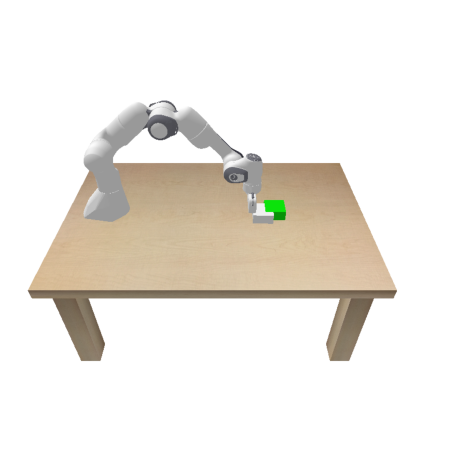

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/My Drive/Colab Notebooks/ROB498/HW3/learning_state_dynamics.py:407: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  cost[i] = (state[i,:]- target_pose)@ Q @ (state[i,:] - target_pose).T


GOAL REACHED: True


In [ ]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)


env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, pushing_residual_dynamics_model, free_pushing_cost_function, num_samples=100, horizon=10)
env.reset()

state_0 = env.reset()
state = state_0

# num_steps_max = 100
num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_FREE
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')
        
        
plt.close(fig)




### 4.2 - Pushing with Obstacles (15 points)
Now, we will repeat the task but adding an obstacle to the scene. The goal is to push the block to the goal while avoiding the obstacle.
You will have to first implement a basic collision detection algorithm. 

Then, you will have to use the collision detection inside the cost function to assign high cost to in-collision trajectories

#### 4.2.1 - Collision Detection Function (5 points)

The obstacle we are considering is a rectangle. At a given SE2 pose $[x, y, \theta]$ we can check collision by checking whether or not these two rectangles intersect. 

![Action Space](https://drive.google.com/uc?export=view&id=1yC2SxtbtmhInkYk-rzR2TAAYuD4JM-I0)

**TODO:**
* Implement `collision_detection` in `learning_state_dynamics.py`.
* The relevant parameters $(w, w_{obs} l_{obs}, x_{obs}, y_{obs})$ are already specified inside the function as `box_size`, `obstacle_dims`, and `obstacle_centre`. 


In [ ]:
from learning_state_dynamics import collision_detection

# let's test the collision detection with two states
# The first should be in collision, the second should not

states = torch.tensor([
    [0.6, 0.2, 0.0],
    [0.3, 0.15, 0.7]
])

collision = collision_detection(states)

print(f'First state in collision? {collision[0]}')
print(f'Second state in collision? {collision[1]}')


First state in collision? 1
Second state in collision? 0


#### 4.2.2 - Cost Function for Obstacle Avoidance (10 points)

You should implement a new cost function to reach the goal while avoiding the obstacle. The cost should be
$$\text{Cost}(\mathbf x_1, ..., \mathbf x_T) = \sum^T_{t=1} \left((\mathbf x_t - \mathbf x_{goal})^T Q (\mathbf x_t - \mathbf x_{goal}) + 100 \texttt{in\_collision}(\mathbf x_t)\right)$$

With $Q$ defined as in the obstacle-free case, and `in_collision` is the binary output of the collision detection function you implemented above. This should add an additional state cost of 100 whenever a state is in collision.

**TODO:**

* Implement `obstacle_avoidance_pushing_cost_function` in `learning_state_dynamics.py`.

If implemented successfully, you should see the robot pushing the block around the obstacle to the goal. The robot should complete the task within the 20 steps, but may take 15-20 steps to do so. Even with a good dynamics model the robot may occasionally get the block stuck on the obstacle, but should complete the task successfully more often than not.

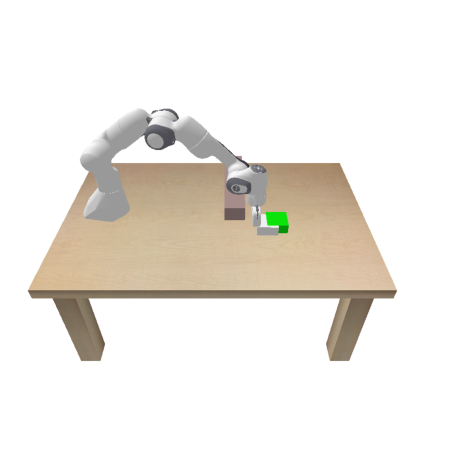

  0%|          | 0/20 [00:00<?, ?it/s]

GOAL REACHED: True


In [ ]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# set up controller and environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  include_obstacle=True, camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, pushing_multistep_residual_dynamics_model,
                               obstacle_avoidance_pushing_cost_function, num_samples=1000, horizon=20)
env.reset()

state_0 = env.reset()
state = state_0

num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_OBSTACLES
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')
        
        
# Evaluate state
plt.close(fig)